In [0]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from datetime import datetime
import math
from sklearn.model_selection import train_test_split
%matplotlib inline


In [0]:
df = pd.read_csv("/dbfs/FileStore/shared_uploads/chien.liu@hellofresh.com/after_covid_daily.csv", parse_dates=['ds'])
df_covid = pd.read_csv("/dbfs/FileStore/shared_uploads/chien.liu@hellofresh.com/Covid.csv")

#Define Setting

In [0]:
df_input = df[['ds', 'simulated']]
df_input = df_input.rename(columns = {'simulated' : 'activations'})
df_input['ds'] =  pd.to_datetime(df_input['ds'])
df_input.head()

,ds,activations
0,2022-03-01 00:00:00+00:00,3007
1,2022-03-02 00:00:00+00:00,3313
2,2022-03-03 00:00:00+00:00,2827
3,2022-03-04 00:00:00+00:00,2974
4,2022-03-05 00:00:00+00:00,2914


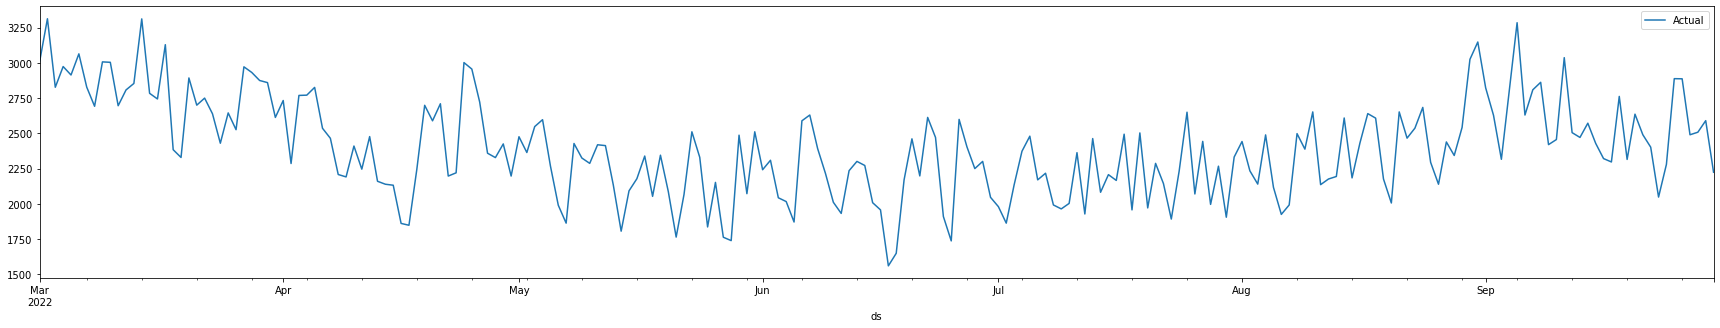

In [0]:
f, ax = plt.subplots(figsize=(30, 5))

df_input.plot(kind='line',x='ds', y='activations', label='Actual', ax=ax)
plt.legend()
plt.show()

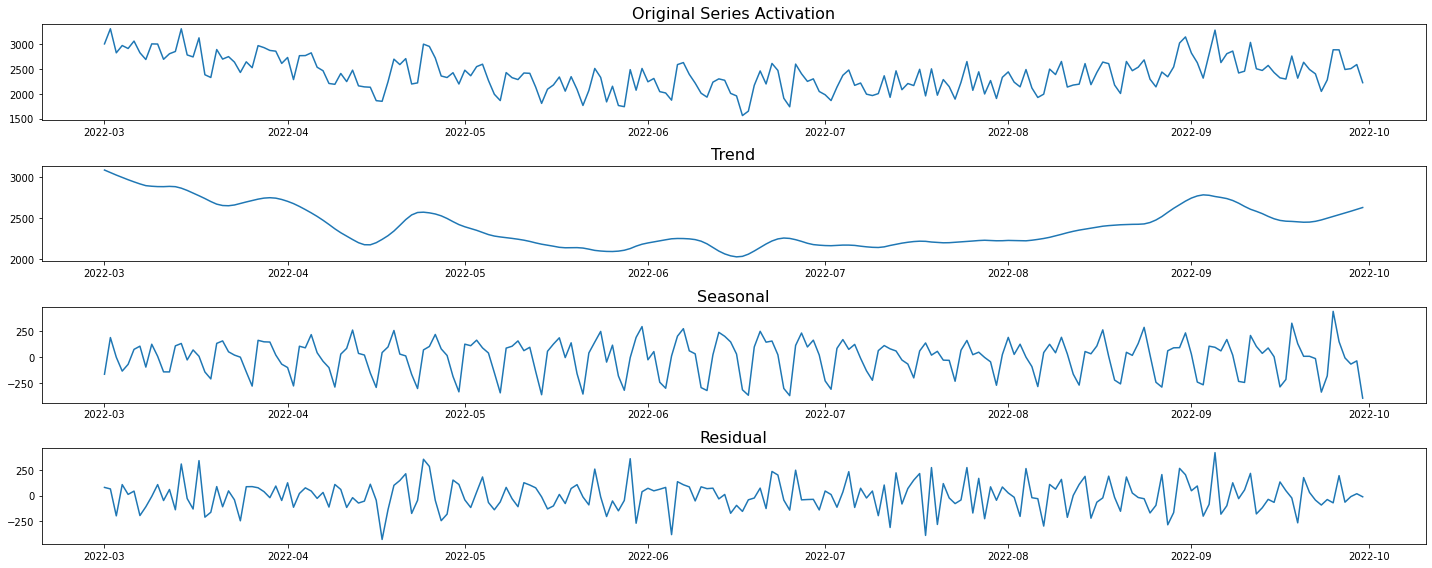

In [0]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL

stl_conversions = STL(df_input.set_index(['ds']))
result_conversions = stl_conversions.fit()

seasonal_conversions, trend_conversions, resid_conversions = result_conversions.seasonal, result_conversions.trend, result_conversions.resid

plt.figure(figsize=(20,8))


plt.subplot(4,1,1)
plt.plot(df_input.set_index(['ds']))
plt.title('Original Series Activation', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend_conversions)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal_conversions)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid_conversions)
plt.title('Residual', fontsize=16)

plt.tight_layout()

#Train and Test Split

In [0]:
train_df = df_input.iloc[:int(len(df_input)*0.8)]
train_df_index = train_df.set_index(['ds'])
test_df = df_input.iloc[int(len(df_input)*0.8):]
test_df_index = test_df.set_index(['ds'])

print('train:', len(train_df), ' test:', len(test_df), ' total:', len(df_input))

## train_df >> 01.03 to 27.07
## train_df >> 28.07 to 30.09

train: 171  test: 43  total: 214


#mul-mul

##Train

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


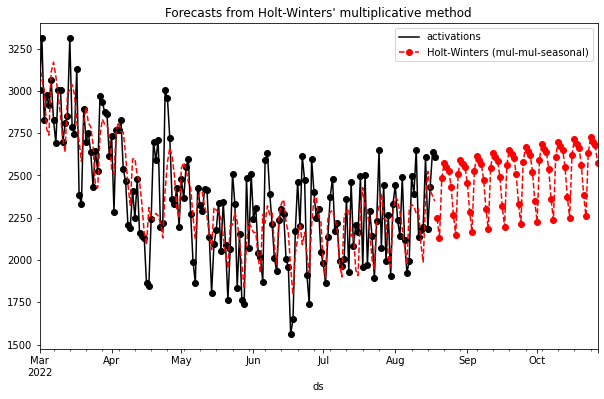

,Additive Dam
alpha,1.817857e-01
beta,1.000000e-04
phi,9.900000e-01
gamma,6.293957e-02
l0,2.951381e+03
b0,1.007429e+00
SSE,7.966663e+06


In [0]:
fit3 = ExponentialSmoothing(
    train_df_index,
    seasonal_periods=7,
    trend="mul",
    seasonal="mul",
    damped_trend=True,
    # initial_level = 3,
    # initial_trend = 7,
    # initial_seasonal= 5,
    initialization_method="estimated",
    freq = 'D',
).fit()


results = pd.DataFrame(
    index=['alpha', 'beta', 'phi', 'gamma', 'l0', 'b0', 'SSE']
)

params = [
    "smoothing_level",
    "smoothing_trend",
    "damping_trend",
    "smoothing_seasonal",
    "initial_level",
    "initial_trend",
]

results["Additive Dam"] = [fit3.params[p] for p in params] + [fit3.sse]

ax = train_df_index.plot(
    figsize=(10, 6),
    marker="o",
    color="black",
    title="Forecasts from Holt-Winters' multiplicative method",
)

fit3.fittedvalues.plot(ax=ax, style="--", color="red")

fit3.forecast(70).rename("Holt-Winters (mul-mul-seasonal)").plot(
    ax=ax, style="--", marker="o", color="red", legend=True
)

plt.show()
results

In [0]:
fit3_df = fit3.fittedvalues.to_frame()
fit3_df_columns = ['activations']
fit3_df.columns = fit3_df_columns
fit3_df.head()

,activations
ds,
2022-03-01 00:00:00+00:00,3160.936402
2022-03-02 00:00:00+00:00,3067.210234
2022-03-03 00:00:00+00:00,3005.904493
2022-03-04 00:00:00+00:00,2777.099486
2022-03-05 00:00:00+00:00,2737.486498


In [0]:
##historical forecast

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

##original values evaluation

print('R-aquared: ' + str(r2_score(train_df_index, fit3_df)))
print('MAPE: ' + str(mean_absolute_percentage_error(train_df_index, fit3_df)))
print('RMSE', mean_squared_error(train_df_index, fit3_df, squared=False))

R-aquared: 0.6113339637154654
MAPE: 0.07606684718264432
RMSE 215.84409886201973


##Test

In [0]:
forecast_test= fit3.forecast(len(test_df)).to_frame()
forecast_test = forecast_test.reset_index()
forecast_test.columns = ['ds', 'forecasted_activations']
forecast_test_index = forecast_test.set_index(['ds'])
forecast_test_index.tail()

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


,forecasted_activations
ds,
2022-09-26 00:00:00+00:00,2667.742277
2022-09-27 00:00:00+00:00,2641.271405
2022-09-28 00:00:00+00:00,2621.585192
2022-09-29 00:00:00+00:00,2522.764744
2022-09-30 00:00:00+00:00,2347.527160


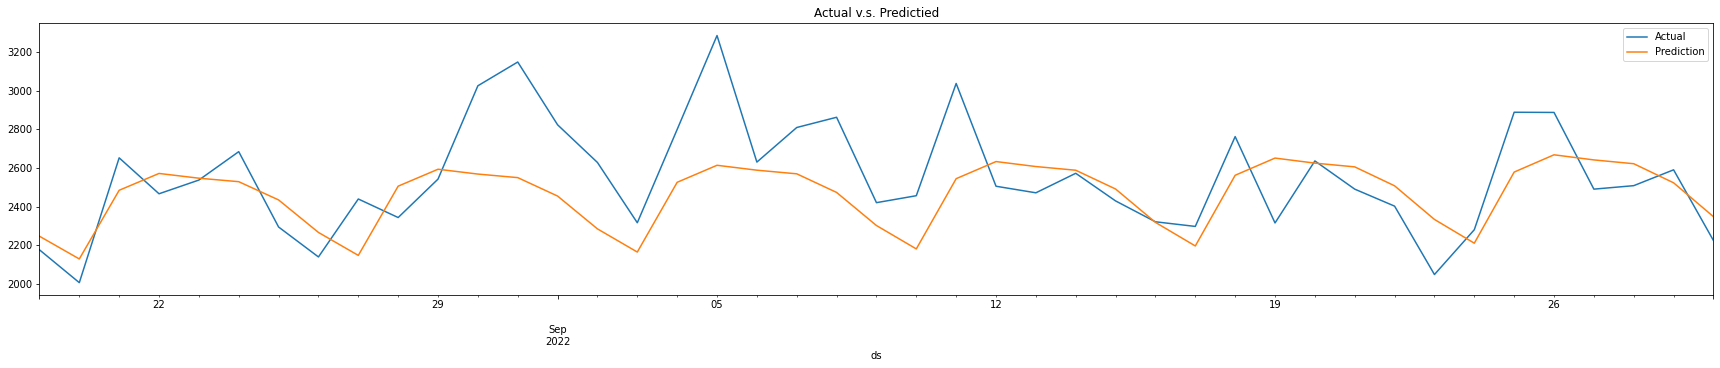

In [0]:
f, ax = plt.subplots(figsize=(30, 5))

test_df.plot(kind='line',x='ds', y='activations', label='Actual', ax=ax)
forecast_test.plot(kind='line',x='ds', y='forecasted_activations', label='Prediction', ax=ax)
plt.title('Actual v.s. Predictied')
plt.legend()
plt.show()

In [0]:
##test forecast

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

##original values evaluation

print('R-aquared: ', str(r2_score(test_df_index, forecast_test_index)))
print('MAPE: ' , str(mean_absolute_percentage_error(test_df_index, forecast_test_index)))
print('RMSE', mean_squared_error(test_df_index, forecast_test_index, squared=False))

R-aquared:  0.23036270113800505
MAPE:  0.07341309653510253
RMSE 248.65744225324673


##Forecast

In [0]:
df_input_index = df_input.set_index('ds')

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


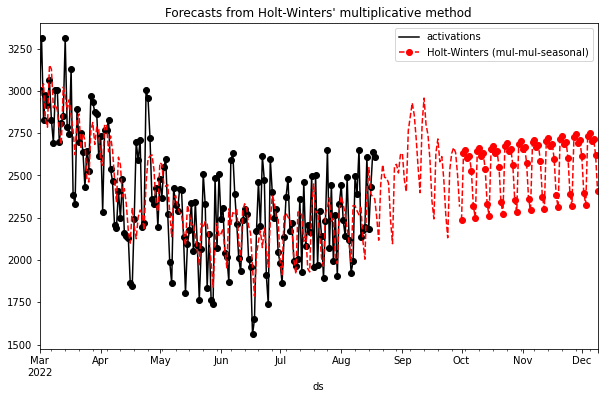

,Additive Dam
alpha,2.171429e-01
beta,1.000000e-04
phi,9.900000e-01
gamma,6.262857e-02
l0,2.951381e+03
b0,1.007429e+00
SSE,1.037695e+07


In [0]:
fit3 = ExponentialSmoothing(
    df_input_index,
    seasonal_periods=7,
    trend="mul",
    seasonal="mul",
    damped_trend=True,
    # initial_level = 3,
    # initial_trend = 7,
    # initial_seasonal= 5,
    initialization_method="estimated",
    freq = 'D',
).fit()


results = pd.DataFrame(
    index=['alpha', 'beta', 'phi', 'gamma', 'l0', 'b0', 'SSE']
)

params = [
    "smoothing_level",
    "smoothing_trend",
    "damping_trend",
    "smoothing_seasonal",
    "initial_level",
    "initial_trend",
]

results["Additive Dam"] = [fit3.params[p] for p in params] + [fit3.sse]

ax = train_df_index.plot(
    figsize=(10, 6),
    marker="o",
    color="black",
    title="Forecasts from Holt-Winters' multiplicative method",
)

fit3.fittedvalues.plot(ax=ax, style="--", color="red")

fit3.forecast(70).rename("Holt-Winters (mul-mul-seasonal)").plot(
    ax=ax, style="--", marker="o", color="red", legend=True
)

plt.show()
results

In [0]:
future_real = pd.read_csv("/dbfs/FileStore/shared_uploads/chien.liu@hellofresh.com/D_Input_new.csv", parse_dates=['ds'])
future_real = future_real[['ds', 'simulated']]
future_real.head()

,ds,simulated
0,2022-09-01 00:00:00+00:00,3234
1,2022-09-02 00:00:00+00:00,2801
2,2022-09-03 00:00:00+00:00,2642
3,2022-09-04 00:00:00+00:00,2884
4,2022-09-05 00:00:00+00:00,3115


In [0]:
future_real_df = future_real[future_real['ds'] >= '2022-10-01']
future_real_df_index = future_real_df.set_index(['ds'])
future_real_df_index.head()

,simulated
ds,
2022-10-01 00:00:00+00:00,2370
2022-10-02 00:00:00+00:00,2355
2022-10-03 00:00:00+00:00,3068
2022-10-04 00:00:00+00:00,2640
2022-10-05 00:00:00+00:00,2602


In [0]:
forecast_future= fit3.forecast(57).to_frame()
forecast_future = forecast_future.reset_index()
forecast_future.columns = ['ds', 'forecasted_activations']
forecast_future_index = forecast_future.set_index(['ds'])
forecast_future_index.tail()

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


,forecasted_activations
ds,
2022-11-22 00:00:00+00:00,2684.886293
2022-11-23 00:00:00+00:00,2697.999140
2022-11-24 00:00:00+00:00,2604.575923
2022-11-25 00:00:00+00:00,2389.708576
2022-11-26 00:00:00+00:00,2318.566031


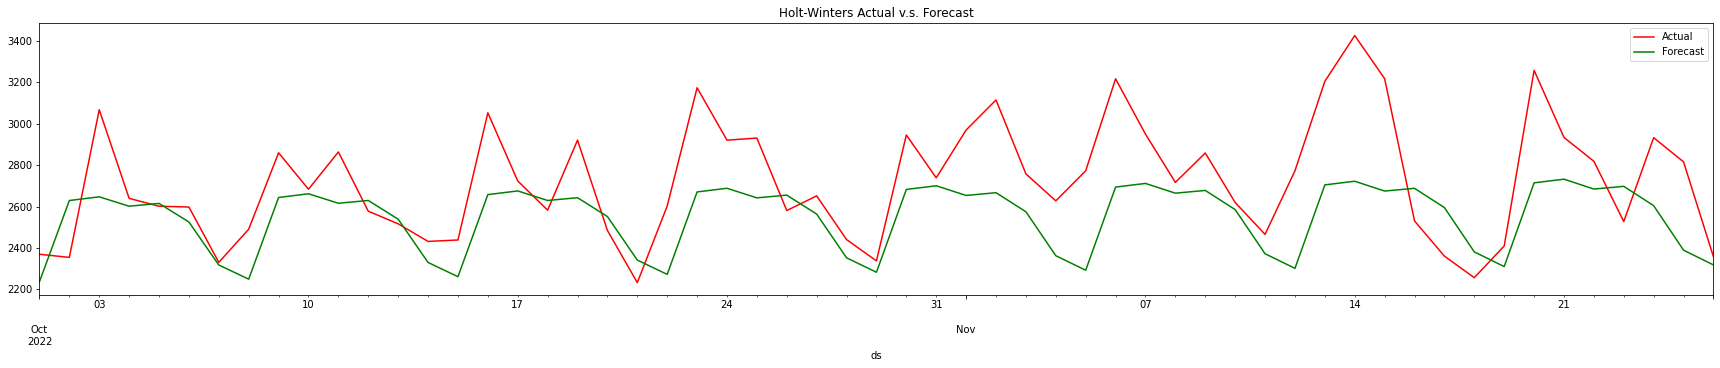

In [0]:
f, ax = plt.subplots(figsize=(30, 5))

future_real_df_index.plot(kind='line',y='simulated', color='red', label='Actual', ax=ax)
forecast_future_index.plot(kind='line',y='forecasted_activations', color='green',label='Forecast', ax=ax)
plt.title('Holt-Winters Actual v.s. Forecast')
plt.legend()
plt.show()

In [0]:
from sklearn.metrics import mean_absolute_percentage_error,  r2_score, mean_squared_error

y_true = future_real_df_index
y_pred = forecast_future_index

print('mape:', mean_absolute_percentage_error(y_true, y_pred))
print('r2:', r2_score(y_true, y_pred))
print('RMSE', mean_squared_error(y_true, y_pred, squared=False))

mape: 0.07635367651073552
r2: 0.046366269796716764
RMSE 277.3901018725354
